In [1]:
import pandas as pd
import os

# mac.osで動かすためのおまじない
os.environ['KMP_DUPLICATE_LIB_OK']='True'

base_dir = "mini_pictures_2"
train_dir = os.path.join(base_dir,"train")
valid_dir = os.path.join(base_dir,"valid")
test_dir = os.path.join(base_dir,"test")
mini_metadata_2 = pd.read_csv('mini_metadata_2.csv',index_col=0)
classes = list(mini_metadata_2["make_model"].value_counts().index)
classes = sorted(classes)
classes_num = len(mini_metadata_2.groupby("make_model"))
print(classes)
print(classes_num)
# mini_metadata.groupby("make_model").nunique()
print(mini_metadata_2["make_model"].value_counts())

['Audi-a5', 'BMW-1-series', 'Honda-pilot', 'Lexus-is-250', 'MINI-countryman', 'Mitsubishi-outlander', 'Nissan-rogue-select', 'Subaru-outback', 'Subaru-xv-crosstrek', 'Volvo-xc60']
10
MINI-countryman         11
Honda-pilot             10
Mitsubishi-outlander    10
Audi-a5                  9
BMW-1-series             9
Lexus-is-250             8
Subaru-outback           8
Nissan-rogue-select      8
Volvo-xc60               7
Subaru-xv-crosstrek      6
Name: make_model, dtype: int64


In [2]:
from keras import layers
from keras import models

# 特徴を抽出
# model.add(layers.Conv2D(フィルターの種類の数, (フィルターの大きさ), activation='活性化関数',
#                input_shape=ここの中身はいじらない(縦, 横, 色の数(奥行き))))
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu',
                       input_shape=(256, 256, 3)))
# 過学習を防ぐためMaxPooling2Dで大事そうなやつだけにして情報を減らす
# 今回は一層と全結合によるモデルを作成する

# 特徴をもとにどのクラスに分類するのかの識別器
model_2.add(layers.Flatten())
model_2.add(layers.Dropout(0.3))
# denseは全結合、情報を圧縮する。最初の引数は圧縮した後の数
model_2.add(layers.Dense(256, activation='relu'))
model_2.add(layers.Dense(classes_num, activation='softmax'))

Using TensorFlow backend.
/Users/tatsuki/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tatsuki/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tatsuki/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/tatsuki/opt/anaconda3/lib/pytho





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2064512)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2064512)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               528515328 
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 528,518,794
Trainable params: 528,518,794
Non-trainable params: 0
_________________________________________________________________


In [4]:
from keras import optimizers

# categorical_crossentropy,lr=学習率
# entropyは情報の不確かさの尺度で小さいほど、確かっぽい感じがする
# entropyを使うことで不確かが数値で計算ができるのがよき
# これをめちゃくちゃ小さくできれば多分確からしいからそこを目指したい
model_2.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

In [5]:
from keras.preprocessing.image import ImageDataGenerator
#すべての画像を1/255スケーリング(大きさではなくて光の大きさ)
# deeplearningは計算して重みの更新をするから使う数値は小さい方が良い
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#flow_from_directoryでは、categoricalのラベリングにclassesを参照して、ディレクトリ名から自動的にone-hotエンコードされる
# ここは頑張りましょう、flow_from_directoryと検索したり、本読んだり
train_generator = train_datagen.flow_from_directory(
    train_dir,               #ターゲットディレクトリ
    target_size=(256, 256),  #すべての画像サイズを256*256に変換
    batch_size=32,           #バッチサイズ
    class_mode='categorical',
    classes=classes)#categorical_crossentropyを使用するため多クラスラベルが必要

validation_generator = test_datagen.flow_from_directory(
    valid_dir,               #ヴァリデーションディレクトリ
    target_size=(256, 256),  #すべての画像サイズを256*256に変換
    batch_size=32,           #バッチサイズ、重りの更新をするときになんかごとに重りを変更するか的な
    class_mode='categorical',
    classes=classes)#categorical_crossentropyを使用するため多クラスラベルが必要



Found 845 images belonging to 10 classes.
Found 257 images belonging to 10 classes.


In [6]:
history = model_2.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=5,
                             validation_data=validation_generator,
                             validation_steps=64)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
100/100 [==============================] - 12139s 121s/step - loss: 14.3960 - acc: 0.0989 - val_loss: 14.8065 - val_acc: 0.0814
Epoch 2/5
100/100 [==============================] - 12007s 120s/step - loss: 14.5344 - acc: 0.0983 - val_loss: 14.7977 - val_acc: 0.0819
Epoch 3/5
100/100 [==============================] - 11994s 120s/step - loss: 14.4750 - acc: 0.1019 - val_loss: 14.7977 - val_acc: 0.0819
Epoch 4/5
100/100 [==============================] - 11717s 117s/step - loss: 14.5194 - acc: 0.0992 - val_loss: 14.8153 - val_acc: 0.0808
Epoch 5/5
100/100 [==============================] - 11490s 115s/step - loss: 14.5047 - acc: 0.1001 - val_loss: 14.7801 - val_acc: 0.0830


In [7]:
import json
with open('lay1_CNN_mini_2_history.json', 'w') as f:
    json.dump(history.history, f)

In [8]:
import json
f = open('lay1_CNN_mini_2_history.json', 'r')
history = json.load(f)
f.close()

In [9]:
model_2.save("lay1_CNN_mini_2.h5")

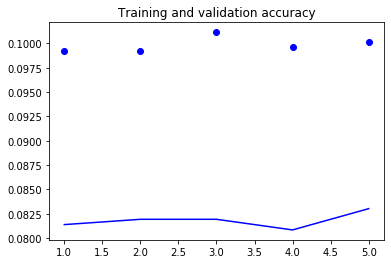

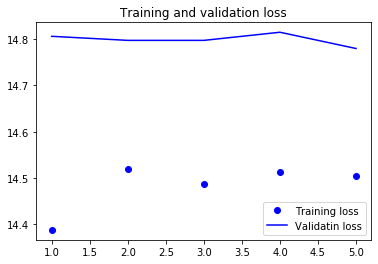

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1,len(acc)+1)

#正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')



#損失値をプロット
plt.figure()# 2枚目の図の下地
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validatin loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()